##  Project Title :
####                       **Customer Review Analytics, Delonghi Coffee Machine- Best Coffee Machine**

##  Group: 
####                BI Strategy Group 2 

##      Part 1 - Web Scrapping

#### Create a connection with Google Spreadsheets API
    -This functions allows exporting files to GoogleSpreadsheets via the API

In [1]:
import datetime
import pickle
import os
from google_auth_oauthlib.flow import Flow, InstalledAppFlow
from googleapiclient.discovery import build
from google.auth.transport.requests import Request


def Create_Service(client_secret_file, api_name, api_version, *scopes):
    print(client_secret_file, api_name, api_version, scopes, sep='-')
    CLIENT_SECRET_FILE = client_secret_file
    API_SERVICE_NAME = api_name
    API_VERSION = api_version
    SCOPES = [scope for scope in scopes[0]]
    print(SCOPES)

    cred = None

    pickle_file = f'token_{API_SERVICE_NAME}_{API_VERSION}.pickle'
    # print(pickle_file)

    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as token:
            cred = pickle.load(token)

    if not cred or not cred.valid:
        if cred and cred.expired and cred.refresh_token:
            cred.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                CLIENT_SECRET_FILE, SCOPES)
            cred = flow.run_local_server()

        with open(pickle_file, 'wb') as token:
            pickle.dump(cred, token)

    try:
        service = build(API_SERVICE_NAME, API_VERSION, credentials=cred)
        print(API_SERVICE_NAME, 'service created successfully')
        return service
    except Exception as e:
        print(e)
    return None

def convert_to_RFC_datetime(year=1900, month=1, day=1, hour=0, minute=0):
    dt = datetime.datetime(year, month, day, hour, minute, 0).isoformat() + 'Z'
    return dt

#### Scrap Data from Amazon,
######                Create Pandas Data Frame and Export to ExcelSheet
#####                  Upload the Excel to Google Spreadsheets  with Google Sheet API
#####                  Translate Title and Comments Columns from German to English 


##### Import Neccessary Libraries and Dependencies for the Webscrap 


In [2]:
# - *- coding: utf- 8 - *-
import numpy as np
import pandas as pd
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import requests
from textblob import TextBlob
import re

##### Scrap Data from Amazon, Create Pandas Data Frame and Export to ExcelSheet

In [4]:
# Create Pandas DataFrame for Scrapped Data
title,comment,rating,date_r,tit_eng,comt_eng = [],[],[],[],[],[]   
translation_cell_counter = 1

# Loop through each page with header to overcome Amazon bot
for i in range (1,200):
    
    headers = {'User-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18362'}
    #my_url = 'https://www.amazon.de/DeLonghi-Siebtr%C3%A4germaschine-Professionelle-Milchschaum-Vollmetallgeh%C3%A4use/product-reviews/B06WGTZ874/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={}'.format(i)
    my_url= 'https://www.amazon.de/DeLonghi-Siebträgermaschine-Professionelle-Milchschaum-Vollmetallgehäuse/product-reviews/B06WGTZ874/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={}'.format(i)
    
    client = requests.get(my_url, headers=headers)
    
    # Download Page as Soup Object
    # Parsing Page --------> (lxml) recommended for Amazon 

    page_soup = soup(client.content, features="lxml")
    
    
    # Grab each customer review profile and comment by container
    # Find the Div containing the customer review profile
    containers= page_soup.findAll("div",{"class":"a-section celwidget"})

    
    
    # Loop through containers for title, comment, rating, date
    for i in range(len(containers)):
        
        tit = containers[i].findAll("span",{"class":""})[0].text
        title.append(tit)

    
        comt = containers[i].findAll("span",{"class":""})[1].text              
        comment.append(comt)
                         
        
        rate = containers[i].findAll("a",{"class":"a-link-normal"})[0].text.split(",")[0]
        rating.append(rate)
        
        # Fro dates, we collect only the year from the text, using a loop
        dates= ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
        def handle_date(a):
            for i in dates:
                if i in a:
                    return (i)
                
        r_date = containers[i].findAll("span",{"data-hook":"review-date"})[0].text
        date_r.append(handle_date(r_date))
        
        
        # For Translation Purposes, We create a row containing formula for Automatic translation on google sheets
        translation_cell_counter = translation_cell_counter + 1 # increment the translation counter
        
        t = '=GOOGLETRANSLATE(A{},"de","en")'.format(translation_cell_counter) # Create the commad for translate on googlsheets
        tit_eng.append(t.strip("'"))                                                    # an example of output  =GOOGLETRANSLATE(A1,"de","en")
         
        # Create the same for the comments translation
        c = '=GOOGLETRANSLATE(B{},"de","en")'.format(translation_cell_counter) 
        comt_eng.append(c.strip("'")) 


# Arrage scrapped Data in Pandas DataFrame
        
c_review = pd.DataFrame({"Title":title,"Comment":comment,"Rating":rating,"Date":date_r,"Title_eng":tit_eng,"Comment_eng":comt_eng, })

File_name = my_url.split("/")[3]+".csv"

#Export Review Dataframe to Excel- FileName derived from the product url for easy refrencing
rev_file = c_review.to_csv(File_name,index=False)
### End of Webscrapper, 




### Now exporting c_review Dataframe to GoogleSpreadsheets 


CLIENT_SECRET_FILE = 'client_secret.json'
API_SERVICE_NAME = 'sheets'
API_VERSION = 'v4'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
gsheetId = '1CkTO6aDsRplMhWSv4vupE0fnTgGbBBkbj7aLEi8lKyk'

service = Create_Service(CLIENT_SECRET_FILE, API_SERVICE_NAME, API_VERSION, SCOPES)

def Export_Data_To_Sheets():
    URL = File_name
    df = pd.read_csv(URL)
    df.replace(np.nan, '', inplace=True)

    response_date = service.spreadsheets().values().append(
        spreadsheetId=gsheetId,
        valueInputOption='RAW',
        range='DF!A1',
        body=dict(
            majorDimension='ROWS',
            values=df.T.reset_index().T.values.tolist())
    ).execute()


Export_Data_To_Sheets()


    

client_secret.json-sheets-v4-(['https://www.googleapis.com/auth/spreadsheets.readonly'],)
['https://www.googleapis.com/auth/spreadsheets.readonly']
sheets service created successfully


##### Import the Translated GoogleSheet
###### Make a copy on LocalPC

In [5]:
def df_from_googlesheets():
    s = Create_Service(CLIENT_SECRET_FILE, API_SERVICE_NAME, API_VERSION, SCOPES)
    gs = s.spreadsheets()
    rows = gs.values().get(spreadsheetId=gsheetId,range='DF').execute()
    data = rows.get('values')
    sheet = pd.DataFrame(data,columns=rows.get('values')[0])
    # Check to see if file exist, Else Save the df as excel 
    checkFile = File_name.split(".")[0]+"_Eng_Translation.xlsx"
    if os.path.isfile(checkFile):
        #os.remove(checkFile)
        print("The DataFrame already exist in the Folder!")
    else:
        sheet.drop(0,inplace=True)
        sheet.to_excel(File_name.split(".")[0]+"_Eng_Translation.xlsx")
        
        return sheet



In [67]:
df.head()

,Title,Comment,Rating,Date
1,Do not buy,Let's start with the positives: DeLonghi is st...,1,2018
2,Reset saves trouble,This is the second machine I have now bought f...,5,2018
3,espresso Siebträgermaschine,"I have me for Christmas from me, for me an esp...",5,2018
4,Big disappointment,We have unfortunately extremely disappointed b...,1,2018
5,short-lived electronic waste,After less than 10 months (rare!) Use and regu...,1,2018


## Part 2 - Data Preparation and Visualizations
-   In this section, we carry out the following operations
    

#### import libraries

In [6]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#### import scrapped customer review file
    --Note: For this section, We shall be working with the translated Columns Title_eng and Comment_eng

In [37]:
# We can export the df_from_goolesheets() into a variabble as a data frame
df = df_from_googlesheets()
# We select the Columns We need in our data frame


client_secret.json-sheets-v4-(['https://www.googleapis.com/auth/spreadsheets.readonly'],)
['https://www.googleapis.com/auth/spreadsheets.readonly']
sheets service created successfully


In [38]:
df.head()

,Title,Comment,Rating,Date,Title_eng,Comment_eng
1,Nicht kaufen,Fangen wir mit dem Positiven an: DeLonghi ist ...,1,2018,Do not buy,Let's start with the positives: DeLonghi is st...
2,Reset erspart Ärger,"Das ist bereits die zweite Maschine, die ich j...",5,2018,Reset saves trouble,This is the second machine I have now bought f...
3,Espresso Siebträgermaschine,"Ich habe mir zu Weihnachten von mir, für mich ...",5,2018,espresso Siebträgermaschine,"I have me for Christmas from me, for me an esp..."
4,Große Enttäuschung,Wir sind von der Delonghi Siebträgermadchine E...,1,2018,Big disappointment,We have unfortunately extremely disappointed b...
5,kurzlebiger Elektroschrott,Nach weniger als 10 Monaten (seltener!) Benutz...,1,2018,short-lived electronic waste,After less than 10 months (rare!) Use and regu...


In [39]:
df = df[["Title_eng","Comment_eng","Rating","Date"]]
df.columns=["Title","Comment","Rating","Date"]

In [40]:
df.head()

,Title,Comment,Rating,Date
1,Do not buy,Let's start with the positives: DeLonghi is st...,1,2018
2,Reset saves trouble,This is the second machine I have now bought f...,5,2018
3,espresso Siebträgermaschine,"I have me for Christmas from me, for me an esp...",5,2018
4,Big disappointment,We have unfortunately extremely disappointed b...,1,2018
5,short-lived electronic waste,After less than 10 months (rare!) Use and regu...,1,2018


#### Divide the data into groups by date [2009-2014], 2015, 2016, 2017, 2018, 2019

In [42]:
df_2014 = df[df["Date"]<='2014']
df_2015 = df[df["Date"]=='2015']
df_2016 = df[df["Date"]=='2016']
df_2017 = df[df["Date"]=='2017']
df_2018 = df[df["Date"]=='2018']
df_2019 = df[df["Date"]=='2019']

#### Understanding the Ratings by year_group

In [64]:
## Understanding the Ratings by year_group
#2014
#df_rt_2014 = df_2014.groupby(by=['Rating'],as_index=False).count().sort_values(by='Rating',ascending=False)

#2015
df_rt_2015 = df_2015.groupby(by=['Rating'],as_index=False).count().sort_values(by='Rating',ascending=False)

#2016
#df_rt_2016 = df_2016.groupby(by=['Rating'],as_index=False).count().sort_values(by='Rating',ascending=False)

#2017
df_rt_2017 = df_2017.groupby(by=['Rating'],as_index=False).count().sort_values(by='Rating',ascending=False)
#2018
df_rt_2018 = df_2018.groupby(by=['Rating'],as_index=False).count().sort_values(by='Rating',ascending=False)
#2019
df_rt_2019 = df_2019.groupby(by=['Rating'],as_index=False).count().sort_values(by='Rating',ascending=False)

#### Visualizations Showing Distribution of Customer Review Ratings According to Year 

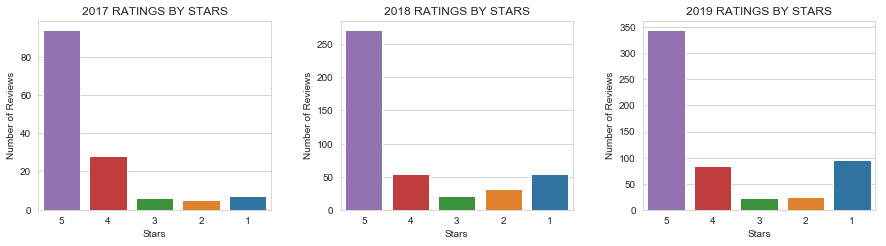

In [65]:
#Define the Main Plot
plt.figure(figsize=(15,8))

sns.set_style("whitegrid")
'''

plt.subplot(231)

ax = sns.barplot(x=df_rt_2014['Rating'],y=df_rt_2014['Title'], data=df_rt_2014)
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.title("2014 RATINGS BY STARS")
ax.invert_xaxis()

plt.subplot(232)
ax = sns.barplot(x=df_rt_2015['Rating'],y=df_rt_2015['Title'], data=df_rt_2015)
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.title("2015 RATINGS BY STARS")
ax.invert_xaxis()

plt.subplot(233)
ax = sns.barplot(x=df_rt_2016['Rating'],y=df_rt_2016['Title'], data=df_rt_2016)
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.title("2016 RATINGS BY STARS")
ax.invert_xaxis()

'''
plt.subplot(234)
ax = sns.barplot(x=df_rt_2017['Rating'],y=df_rt_2017['Title'], data=df_rt_2017)
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.title("2017 RATINGS BY STARS")
ax.invert_xaxis()

plt.subplot(235)
ax = sns.barplot(x=df_rt_2018['Rating'],y=df_rt_2018['Title'], data=df_rt_2018)
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.title("2018 RATINGS BY STARS")
ax.invert_xaxis()

plt.subplot(236)
ax = sns.barplot(x=df_rt_2019['Rating'],y=df_rt_2019['Title'], data=df_rt_2019)
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.title("2019 RATINGS BY STARS")
ax.invert_xaxis()

plt.subplots_adjust(wspace=.3)
plt.subplots_adjust(hspace=.3)


### Analyzing the Titles for 2009-2014
##### Word Normalization, 
##### Tokenization, 
##### Lemmatization 
##### StopWords removal

In [66]:
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
from stop_words import get_stop_words
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#from collections import Counter
#from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words
#from nltk.corpus import wordnet
#from nltk.stem import WordNetLemmatizer


In [44]:
# Reduce all words to lowercase and concatenate together into one text file
a = df_2014['Title'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

# Lemmatizing (Reduce words to their original english root = Lemmas)and Tokenizing (Break words into Tokens)
# Lemmatizing with POS Tag ensures that the word is handled depending on its position and Function in the sentence (Verb,Adjective,Noun,Adverb)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemma = WordNetLemmatizer()
lemmad_list = [lemma.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(b)]


#Prepare a list of English Stopwords
stop_words = list(get_stop_words('en')) # contains list of 124 English stopwords
nltk_words = list(stopwords.words('english')) # contains another list of stopwords 174
stop_words.extend(nltk_words)


# Now remove the Stopwords from the Tokenized List
filtered_sentence = [w for w in lemmad_list if not w in stop_words]
'''This can also be done using a loop like this 
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
'''

# Remove words which have less than 2 characters
words_without_char = [w for w in filtered_sentence if len(w) > 2]

# Then remove any occurrence of numbers
cleaned_data_title = [word for word in words_without_char if not word.isnumeric()]  


## Part 3- Indepth Analytics and Visualizations

### Analyzing Titles and Comments For [2009 - 2014]

#### Calculate frequency distribution for words in Customer Review Titles for 2009 - 2014

In [115]:
# Variable to hold top 100
top_N = 50

# Calculate frequency distribution of words as they appear in the title for 2014
word_dist = nltk.FreqDist(cleaned_data_title)
result = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

#Show Top 20 words
result.head(20)

,Word,Frequency
0,coffee,42
1,machine,35
2,good,27
3,great,12
4,delonghi,12
5,ecam,11
6,fully,10
7,automatic,9
8,well,8
9,super,7


#### Visualization of top 20 words in Customer Review Titles 2009 - 2014

Text(0.5, 1.0, 'Top 20 Most Used Words in Customer Review Title 2009-2014 ')

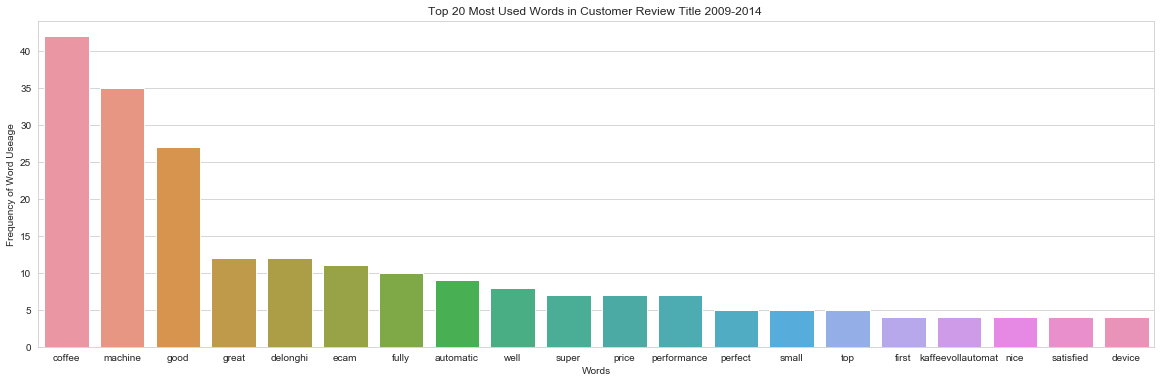

In [116]:
# Create a Barplot showing the most frequent words
plt.figure(figsize=(20,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=result.head(20))
plt.xlabel("Words")
plt.ylabel("Frequency of Word Useage")
plt.title("Top 20 Most Used Words in Customer Review Title 2009-2014 ")

#### WordCloud for Words in 2014 Title

In [118]:

# Function to create WordCloud
def wc(data,bgcolor,title):
    plt.figure(figsize = (15,15))
    wc = WordCloud(background_color = bgcolor, max_words = 50,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')
    

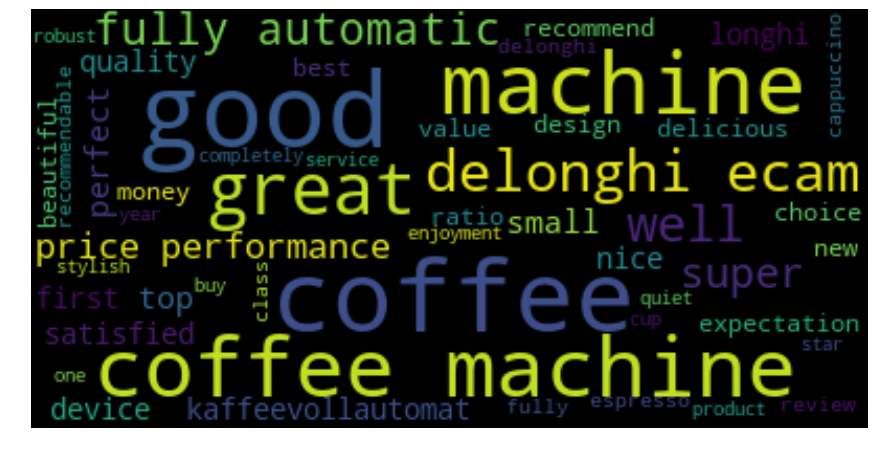

In [119]:

# WordCloud for customer Review Title 2009-2014
wc(cleaned_data_title,'black','Common Words' )

#### Let's Analyze the Comments for 2009 - 2014

In [134]:
# Reduce all words to lowercase and concatenate together into one text file
a_comm_2014 = df_2014['Comment'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b_comm_2014 = re.sub('[^A-Za-z]+', ' ', a_comm_2014)

# Lemmatizing (Reduce words to their original english root = Lemmas)and Tokenizing (Break words into Tokens)
# Lemmatizing with POS Tag ensures that the word is handled depending on its position and Function in the sentence (Verb,Adjective,Noun,Adverb)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemma_comm_2014 = WordNetLemmatizer()
lemmad_list_comm_2014 = [lemma_comm_2014.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(b_comm_2014)]


#Prepare a list of English Stopwords
stop_words_comm_2014 = list(get_stop_words('en')) # contains list of 124 English stopwords
nltk_words_comm_2014 = list(stopwords.words('english')) # contains another list of stopwords 174
stop_words_comm_2014.extend(nltk_words_comm_2014)


# Now remove the Stopwords from the Tokenized List
filtered_sentence_comm_2014 = [w for w in lemmad_list_comm_2014 if not w in stop_words_comm_2014]
'''This can also be done using a loop like this 
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
'''

# Remove words which have less than 2 characters
words_without_char_comm_2014 = [w for w in filtered_sentence_comm_2014 if len(w) > 2]

# Then remove any occurrence of numbers
cleaned_data_title_comm_2014 = [word for word in words_without_char_comm_2014 if not word.isnumeric()]  



In [ ]:
#### Calculate frequency distribution for words in Customer Review Comments for 2009 - 2014

In [136]:
# Variable to hold top 100
top_N_comm_2014 = 50

# Calculate frequency distribution of words as they appear in the title for 2014
word_dist_comm_2014 = nltk.FreqDist(cleaned_data_title_comm_2014)
result_comm_2014 = pd.DataFrame(word_dist_comm_2014.most_common(top_N_comm_2014), columns=['Word', 'Frequency'])

#Show Top 20 words
result_comm_2014.head(20)

,Word,Frequency
0,coffee,459
1,machine,339
2,water,151
3,cup,130
4,good,119
5,use,91
6,also,90
7,easy,81
8,well,74
9,taste,73


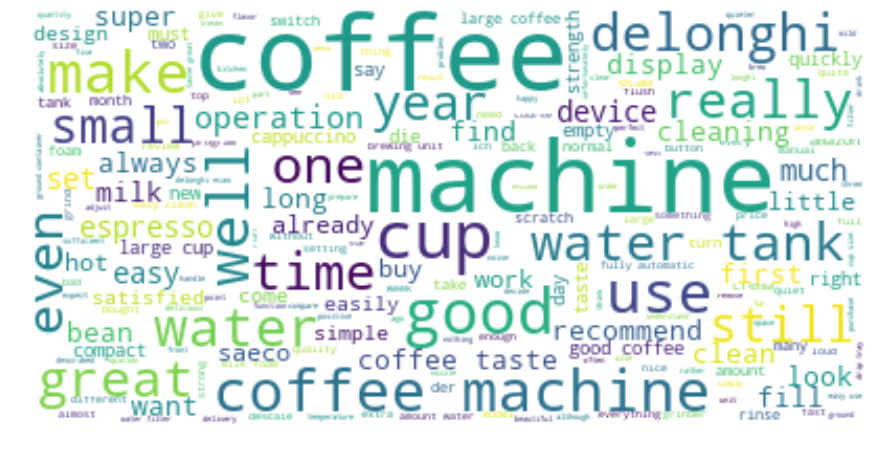

In [141]:
# Function to create WordCloud
def wc(data,bgcolor,title):
    plt.figure(figsize = (15,15))
    wc = WordCloud(background_color = bgcolor, max_words = 200,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')
    
    
# WordCloud for customer Review Title 2009-2014
wc(cleaned_data_title_comm_2014,'white','Common Words' )

### Analyzing Titles and Comments For 2015

#### Now we turn the code block from 2014 Analysis into a Function to Analyze Comments and Titles for all other years

In [47]:

def review_analyzer(a):
    # Reduce all words to lowercase and concatenate together into one text file
    a = a.str.lower().str.cat(sep=' ')
    # removes punctuation,numbers and returns list of words
    b = re.sub('[^A-Za-z]+', ' ', a)

    # Lemmatizing (Reduce words to their original english root = Lemmas)and Tokenizing (Break words into Tokens)
    # Lemmatizing with POS Tag ensures that the word is handled depending on its position and Function in the sentence (Verb,Adjective,Noun,Adverb)

    def get_wordnet_pos(word):
        
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    
    lemma = WordNetLemmatizer()
    lemmad_list = [lemma.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(b)]


    #Prepare a list of English Stopwords
    stop_words = list(get_stop_words('en')) # contains list of 124 English stopwords
    nltk_words = list(stopwords.words('english')) # contains another list of stopwords 174
    stop_words.extend(nltk_words)


    # Now remove the Stopwords from the Tokenized List
    filtered_sentence = [w for w in lemmad_list if not w in stop_words]
    '''This can also be done using a loop like this 
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    '''

    # Remove words which have less than 2 characters
    words_without_char = [w for w in filtered_sentence if len(w) > 2]

    # Then remove any occurrence of numbers
    cleaned_data = [word for word in words_without_char if not word.isnumeric()] 
    return cleaned_data
    
    


# A function for getting the frequency distribution
    
def freq_dist(a):
    # Variable to hold top 50
    top_N = 50

    # Calculate frequency distribution of words 
    word_dist = nltk.FreqDist(a)
    result = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

    #Show Top 20 words from distribution
    return result.head(20)


#### 2015 Titles Analysis

In [48]:
freq_dist(review_analyzer(df_2015['Title']))

,Word,Frequency
0,coffee,28
1,machine,23
2,good,16
3,satisfied,10
4,delonghi,9
5,great,9
6,fully,7
7,top,7
8,ecam,7
9,recommend,7


In [ ]:
freq_dist(review_analyzer(df_2015['Comment']))

### Analyzing Titles and Comments For 2016

In [50]:
freq_dist(review_analyzer(df_2016['Title'])) # titles

,Word,Frequency
0,machine,27
1,coffee,26
2,good,17
3,great,14
4,price,10
5,automatic,10
6,fully,9
7,delonghi,9
8,device,7
9,top,7


In [52]:
freq_dist(review_analyzer(df_2016['Comment'])) #comments

,Word,Frequency
0,coffee,228
1,machine,218
2,water,72
3,delonghi,63
4,good,63
5,use,58
6,year,55
7,cup,55
8,milk,53
9,great,47


### Analyzing Titles and Comments For 2017

In [51]:
freq_dist(review_analyzer(df_2019['Title']))

,Word,Frequency
0,coffee,38
1,good,28
2,machine,21
3,great,15
4,device,12
5,easy,10
6,satisfied,8
7,use,8
8,super,8
9,top,6


In [ ]:
freq_dist(review_analyzer(df_2019['Comment']))

### Analyzing Titles and Comments For 2018

In [ ]:
freq_dist(review_analyzer(df_2019['Title']))

In [ ]:
freq_dist(review_analyzer(df_2019['Comment']))

### Analyzing Titles and Comments For 2019

In [ ]:
freq_dist(review_analyzer(df_2019['Title']))

In [ ]:
freq_dist(review_analyzer(df_2019['Comment']))

### BIGRAMS AND TRIGRAMS

#### Divide Data into Groups According to Ratings

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

In [65]:
# Divide Data into Groups according to Ratings
df_5 = df[df["Rating"]==5]
df_4 = df[df["Rating"]==4]
df_3 = df[df["Rating"]==3]
df_2 = df[df["Rating"]==2]
df_1 = df[df["Rating"]==1]

In [83]:
a = df_1['Title'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemma = WordNetLemmatizer()
lemmad = [lemma.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(df_1['Title'])]

result_lem = pd.DataFrame(lemmad, columns=['Word'])




TypeError: expected string or bytes-like object

In [76]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_bigram(result_lem['Word'], 20)
for word, freq in common_words:
    print(word, freq)
    
df4 = pd.DataFrame(common_words, columns = ['Title' , 'count'])


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [67]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_bigram(df_1['Title'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['Title' , 'count'])



defective after 4
never again 4
coffee machine 4
after the 2
the warranty 2
good coffee 2
grinder defective 2
after months 2
is not 2
does not 2
de longhi 2
already defective 2
defective in 2
again delonghi 2
after years 2
three weeks 2
after weeks 2
30 days 2
delicious coffee 1
coffee with 1


In [161]:
## Analyze 2015 Comments

# Reduce all words to lowercase and concatenate together into one text file
a_comm_2015 = df_2015['Comment'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b_comm_2015 = re.sub('[^A-Za-z]+', ' ', a_comm_2015)

# Lemmatizing (Reduce words to their original english root = Lemmas)and Tokenizing (Break words into Tokens)
# Lemmatizing with POS Tag ensures that the word is handled depending on its position and Function in the sentence (Verb,Adjective,Noun,Adverb)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemma_comm_2015 = WordNetLemmatizer()
lemmad_list_comm_2015 = [lemma_comm_2015.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(b_comm_2015)]


#Prepare a list of English Stopwords
stop_words_comm_2015 = list(get_stop_words('en')) # contains list of 124 English stopwords
nltk_words_comm_2015 = list(stopwords.words('english')) # contains another list of stopwords 174
stop_words_comm_2015.extend(nltk_words_comm_2015)


# Now remove the Stopwords from the Tokenized List
filtered_sentence_comm_2015 = [w for w in lemmad_list_comm_2015 if not w in stop_words_comm_2015]
'''This can also be done using a loop like this 
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
'''

# Remove words which have less than 2 characters
words_without_char_comm_2015 = [w for w in filtered_sentence_comm_2015 if len(w) > 2]

# Then remove any occurrence of numbers
cleaned_data_title_comm_2015 = [word for word in words_without_char_comm_2015 if not word.isnumeric()]  






# Variable to hold top 100
top_N_comm_2015 = 50

# Calculate frequency distribution of words as they appear in the title for 2014
word_dist_comm_2015 = nltk.FreqDist(cleaned_data_title_comm_2015)
result_comm_2015 = pd.DataFrame(word_dist_comm_2015.most_common(top_N_comm_2015), columns=['Word', 'Frequency'])

#Show Top 20 words
result_comm_2015.head(20)

,Word,Frequency
0,coffee,334
1,machine,217
2,water,134
3,cup,80
4,milk,77
5,good,74
6,use,73
7,also,62
8,easy,59
9,make,54


#### A DEEPER DIVE...... CLUSTERING

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
vectorizer = TfidfVectorizer(stop_words="english")
features = vectorizer.fit_transform(document)